In [2]:
import sqlalchemy

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import os
import numpy
import ast

In [3]:
hostname='localhost'
dbname = 'congressional_bills'
username = 'melissaferrari'

### Database connection with sqlalchemy.

In [4]:
#engine = create_engine('postgres://{}@{}/{}'.format(hostname, username, dbname))
engine = create_engine('postgres://{}/{}'.format(hostname, dbname))

In [5]:
print(engine.url)

postgres://localhost/congressional_bills


In [6]:
## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


### Load in csv data.

In [7]:
def import_csv(file_path):
    df = pd.read_csv(file_path)
    if 'Unnamed: 0' in df.columns:
        del df['Unnamed: 0']
    return df

### Create legislator database table.
The legislator table is flat and simply a copy of the csv file downloaded, so I will use `pandas` function `to_sql` for simplicity.

[Legislator Data Glossary](https://github.com/unitedstates/congress-legislators)

In [10]:
leg_hist = import_csv(os.path.join(data_path, 'legislators-historical.csv'))
leg_hist['current_legislator'] = False 
leg_hist.head()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,...,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id,current_legislator
0,Bassett,Richard,NaN,NaN,NaN,NaN,1745-04-02,M,sen,DE,...,NaN,NaN,NaN,401222,NaN,NaN,NaN,507.0,Richard Bassett (politician),False
1,Bland,Theodorick,NaN,NaN,NaN,NaN,1742-03-21,M,rep,VA,...,NaN,NaN,NaN,401521,NaN,NaN,NaN,786.0,Theodorick Bland (congressman),False
2,Burke,Aedanus,NaN,NaN,NaN,NaN,1743-06-16,M,rep,SC,...,NaN,NaN,NaN,402032,NaN,NaN,NaN,1260.0,Aedanus Burke,False
3,Carroll,Daniel,NaN,NaN,NaN,NaN,1730-07-22,M,rep,MD,...,NaN,NaN,NaN,402334,NaN,NaN,NaN,1538.0,Daniel Carroll,False
4,Clymer,George,NaN,NaN,NaN,NaN,1739-03-16,M,rep,PA,...,NaN,NaN,NaN,402671,NaN,NaN,NaN,1859.0,George Clymer,False


In [11]:
leg_current = import_csv(os.path.join(data_path, 'legislators-current.csv'))
leg_current['current_legislator'] = True
leg_current.head()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,...,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id,current_legislator
0,Brown,Sherrod,NaN,NaN,NaN,Sherrod Brown,1952-11-09,M,sen,OH,...,S307,"H2OH13033,S6OH00163",5051.0,400050,27018.0,Sherrod Brown,NaN,29389.0,Sherrod Brown,True
1,Cantwell,Maria,NaN,NaN,NaN,Maria Cantwell,1958-10-13,F,sen,WA,...,S275,"S8WA00194,H2WA01054",26137.0,300018,27122.0,Maria Cantwell,NaN,39310.0,Maria Cantwell,True
2,Cardin,Benjamin,L.,NaN,NaN,Benjamin L. Cardin,1943-10-05,M,sen,MD,...,S308,"H6MD03177,S6MD03177",4004.0,400064,26888.0,Ben Cardin,NaN,15408.0,Ben Cardin,True
3,Carper,Thomas,Richard,NaN,NaN,Thomas R. Carper,1947-01-23,M,sen,DE,...,S277,S8DE00079,663.0,300019,22421.0,Tom Carper,NaN,15015.0,Tom Carper,True
4,Casey,Robert,P.,Jr.,Bob,"Robert P. Casey, Jr.",1960-04-13,M,sen,PA,...,S309,S6PA00217,47036.0,412246,2541.0,"Bob Casey, Jr.",NaN,40703.0,Bob Casey Jr.,True


In [12]:
leg_all = pd.concat([leg_current, leg_hist])

In [13]:
len(leg_current) + len(leg_hist) == len(leg_all.drop_duplicates())

True

In [14]:
#leg_all.to_csv(os.path.join(data_path, 'legislators-all.csv'))
leg_all = import_csv(os.path.join(data_path, 'legislators-all.csv'))

In [15]:
leg_all.head()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,...,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id,current_legislator
0,Brown,Sherrod,NaN,NaN,NaN,Sherrod Brown,1952-11-09,M,sen,OH,...,S307,"H2OH13033,S6OH00163",5051.0,400050,27018.0,Sherrod Brown,NaN,29389.0,Sherrod Brown,True
1,Cantwell,Maria,NaN,NaN,NaN,Maria Cantwell,1958-10-13,F,sen,WA,...,S275,"S8WA00194,H2WA01054",26137.0,300018,27122.0,Maria Cantwell,NaN,39310.0,Maria Cantwell,True
2,Cardin,Benjamin,L.,NaN,NaN,Benjamin L. Cardin,1943-10-05,M,sen,MD,...,S308,"H6MD03177,S6MD03177",4004.0,400064,26888.0,Ben Cardin,NaN,15408.0,Ben Cardin,True
3,Carper,Thomas,Richard,NaN,NaN,Thomas R. Carper,1947-01-23,M,sen,DE,...,S277,S8DE00079,663.0,300019,22421.0,Tom Carper,NaN,15015.0,Tom Carper,True
4,Casey,Robert,P.,Jr.,Bob,"Robert P. Casey, Jr.",1960-04-13,M,sen,PA,...,S309,S6PA00217,47036.0,412246,2541.0,"Bob Casey, Jr.",NaN,40703.0,Bob Casey Jr.,True


In [90]:
## insert data into database from Python (proof of concept - this won't be useful for big data, of course)
#leg_all.to_sql('legislators', con=engine, if_exists='replace', index_label='id')

In [16]:
bill_type = ['hr', 'hres', 'hjres', 'hconres', 's', 'sres', 'sjres', 'sconres']
bill_type_df = pd.DataFrame({'name':bill_type})

In [379]:
#bill_type_df.to_sql('lk_bill_type', con=engine, index_label='id', dtype={"name": sqlalchemy.types.String(8)})

# Data Cleaning.

### Bill versions.

In [466]:
cd data_files/

/Users/melissaferrari/Projects/repo/bill-summarization/data_files


In [467]:
ls

bill_details/               legislators-all.csv
bill_version.csv            legislators-current.csv
committees-current.json     legislators-historical.csv
committees-historical.json


In [469]:
#bill_versions = pd.read_csv(os.path.join(data_path, 'bill_version.csv'))
bill_versions = pd.read_csv('bill_version.csv')
bill_versions.columns = ['title', 'code', 'definition', 'chamber']

In [475]:
sql = """SELECT DISTINCT "as" FROM summaries;"""

In [19]:
## insert data into database from Python (proof of concept - this won't be useful for big data, of course)
bill_versions.to_sql('bill_versions', con=engine, if_exists='replace', index_label='id')

### Open aggregated data.

In [161]:
data_path = '/Users/melissaferrari/Projects/repo/bill-summarization/'
data_path += 'data_files/bill_details'
file_name = 'agg_propublica_114hr.csv'
#file_name = 'agg_propublica_113hr.csv'
df = import_csv(os.path.join(data_path, file_name))
data_agg = df.copy()

In [162]:
data_dont_touch = data_agg.copy()

In [27]:
data_agg.head(2)

,actions,amendments,bill_id,bill_type,by_request,committee_reports,committees,congress,cosponsors,enacted_as,...,short_title,sponsor,status,status_at,subjects,subjects_top_term,summary,titles,updated_at,url
0,"[{'acted_at': '2015-03-03', 'references': [], ...",[],hr1216-114,hr,False,[],"[{'committee_id': 'HSBA', 'activity': ['referr...",114,"[{'withdrawn_at': None, 'district': '7', 'spon...",NaN,...,Maker-Taker Conflict of Interest Reform Act of...,"{'district': '8', 'type': 'person', 'title': '...",REFERRED,2015-03-03,"['Congressional oversight', 'Finance and finan...",Finance and financial sector,"{'date': '2015-03-03T05:00:00Z', 'text': 'Make...",[{'title': 'Maker-Taker Conflict of Interest R...,2017-12-11T19:28:52Z,https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/...
1,"[{'acted_at': '2016-03-16', 'references': [], ...",[],hr4764-114,hr,False,[],"[{'committee_id': 'HSVR', 'activity': ['referr...",114,"[{'withdrawn_at': None, 'district': '12', 'spo...",NaN,...,Puppies Assisting Wounded Servicemembers (PAWS...,"{'district': '6', 'type': 'person', 'title': '...",REFERRED,2016-03-16,"['Armed forces and national security', 'Health...",Armed forces and national security,"{'date': '2016-03-16T04:00:00Z', 'text': 'Pupp...",[{'title': 'Puppies Assisting Wounded Servicem...,2017-12-11T21:02:18Z,https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/...


#### Unpack sponsor dictionary.
This has been migrated to `insert_bill_data.py`

In [28]:
sponsor_dict = data_agg['sponsor'].apply(ast.literal_eval).values.tolist()
sponsor_df = pd.DataFrame(sponsor_dict, index=data_agg.index)[['bioguide_id']]

In [29]:
data_agg = data_agg.merge(sponsor_df, left_index=True, right_index=True)
del data_agg['sponsor']

#### Clean bill title data.
This has been migrated to `insert_bill_data.py`

In [22]:
data_agg[['short_title', 'official_title', 'popular_title']].head()

,short_title,official_title,popular_title
0,Maker-Taker Conflict of Interest Reform Act of...,To require the Securities and Exchange Commiss...,NaN
1,Puppies Assisting Wounded Servicemembers (PAWS...,To direct the Secretary of Veterans Affairs to...,NaN
2,Maritime Lien Reform Act,To provide limitations on maritime liens on fi...,NaN
3,Adding Middle East Respiratory Syndrome to the...,To expand the tropical disease product priorit...,NaN
4,Wounded Warrior Service Dog Act of 2015,To establish a grant program to encourage the ...,NaN


The `titles` dict in the aggregated table data is redundant, so we delete it.

In [23]:
del data_agg['titles']

#### Separate summaries.
This has been migrated to `insert_bill_data.py`

In [34]:
data_summary = data_agg[['summary', 'bill_id', 'congress', 'number', 'bill_type']].copy()
del data_agg['summary']

### Convert appropriate columns to `date` objects

In [ ]:
data_agg['status_at'] = pd.to_datetime(data_agg['status_at']).dt.date

In [43]:
data_agg['introduced_at'] = pd.to_datetime(data_agg['introduced_at']).dt.date

In [44]:
data_agg['updated_at'] = pd.to_datetime(data_agg['updated_at'])

# Separating actions.

In [31]:
data_actions = data_agg[['actions', 'bill_id']].copy()
del data_agg['actions']

# Separating committees.

In [32]:
data_committees = data_agg[['committees', 'bill_id']].copy()
del data_agg['committees']

# Separating amendments.

In [33]:
data_amendments = data_agg[['amendments', 'bill_id']].copy()
del data_agg['amendments']

# Separating committee reports.

In [34]:
data_committee_reports = data_agg[['committee_reports', 'bill_id']].copy()
del data_agg['committee_reports']

# Separating cosponsorship.

In [35]:
data_cosponsors = data_agg[['cosponsors', 'bill_id']].copy()
del data_agg['cosponsors']

# Unpack and separate bill history dictionary.

In [36]:
history_dict = data_agg['history'].apply(ast.literal_eval).values.tolist()
history_df = pd.DataFrame(history_dict, index=data_agg.index)

In [37]:
history_df = data_agg[['bill_id']].merge(history_df, right_index=True, left_index=True)

In [38]:
del data_agg['history']

# Separate related bills.

In [39]:
data_related_bills = data_agg[['related_bills', 'bill_id']].copy()
del data_agg['related_bills']

# Separate subjects.

In [40]:
data_subjects = data_agg[['subjects', 'bill_id']].copy()
del data_agg['subjects']

# Separate enacted_as.

In [35]:
data_enacted_as = data_agg[['enacted_as', 'bill_id']].copy()
del data_agg['enacted_as']

In [36]:
data_agg.columns

Index(['bill_id', 'bill_type', 'by_request', 'congress', 'introduced_at',
       'number', 'official_title', 'popular_title', 'short_title', 'status',
       'status_at', 'subjects_top_term', 'updated_at', 'url', 'bioguide_id'],
      dtype='object')

### Insert remaining data into `bills` table of database.
This has been migrated to `insert_bill_data.py`

In [41]:
list(data_agg.columns)

['bill_id',
 'bill_type',
 'by_request',
 'congress',
 'introduced_at',
 'number',
 'official_title',
 'popular_title',
 'short_title',
 'status',
 'status_at',
 'subjects_top_term',
 'updated_at',
 'url',
 'bioguide_id']

In [807]:
col_names = ['bill_id', 'by_request', 'congress', 'introduced_at',
             'number', 'official_title', 'popular_title', 'short_title',
             'status_at', 'subjects_top_term', 'updated_at', 'url']

relational_cols = ['status', 'bioguide_id', 'bill_type']

data_path = '/Users/melissaferrari/Projects/repo/insight/data_collection'
file_name = 'agg_propublica_114hr.csv'
data_agg = import_csv(os.path.join(data_path, file_name))


In [810]:
data_agg.columns

Index(['actions', 'amendments', 'bill_id', 'bill_type', 'by_request',
       'committee_reports', 'committees', 'congress', 'cosponsors',
       'enacted_as', 'history', 'introduced_at', 'number', 'official_title',
       'popular_title', 'related_bills', 'short_title', 'sponsor', 'status',
       'status_at', 'subjects', 'subjects_top_term', 'summary', 'titles',
       'updated_at', 'url'],
      dtype='object')

## Postgres with psycopg2.

In [495]:
db_conn = psycopg2.connect("host={} dbname={} user={}".format(hostname,
                                                              dbname,
                                                              username))

In [275]:
#db_conn.close()

In [496]:
db_cursor = db_conn.cursor()

In [497]:
search = 'hr1'
sql_query = "SELECT bill_id FROM bills WHERE bill_id LIKE '%" + str(search) + "%' LIMIT 10;"
query = db_cursor.execute(sql_query)

In [502]:
query_list = "SELECT bill_id FROM bills WHERE bill_id LIKE '%" + search + "%' LIMIT 10;"
query_list_results = pd.read_sql_query(query_list, con)
bill_id_list = list(query_list_results['bill_id'])

In [505]:
df_dict = query_list_results.to_dict()
df_dict

{'bill_id': {0: 'hr1216-114',
  1: 'hr1024-114',
  2: 'hr105-114',
  3: 'hr1818-114',
  4: 'hr1440-114',
  5: 'hr1672-114',
  6: 'hr1686-114',
  7: 'hr1827-114',
  8: 'hr1229-114',
  9: 'hr1681-114'}}

In [504]:
bill_id_list

['hr1216-114',
 'hr1024-114',
 'hr105-114',
 'hr1818-114',
 'hr1440-114',
 'hr1672-114',
 'hr1686-114',
 'hr1827-114',
 'hr1229-114',
 'hr1681-114']

#### List tables in database.

In [278]:
db_cursor.execute("""SELECT table_name 
                     FROM information_schema.tables 
                     WHERE table_schema = 'public'""")
for table in db_cursor.fetchall():
    print(table)

('lk_status',)
('related_bills',)
('congresspeople',)
('bill_actions',)
('committees',)
('bill_committee',)
('action_committee',)
('subjects',)
('cosponsorship',)
('summaries',)
('lk_summary_source',)
('bill_text',)
('bills',)
('legislators',)


#### Basic table queries.

In [487]:
db_conn.rollback()

In [489]:
db_cursor.execute('SELECT ls.name FROM lk_status ls')
all_status = db_cursor.fetchall()
all_status

[('ENACTED:SIGNED',),
 ('PASS_OVER:HOUSE',),
 ('REPORTED',),
 ('REFERRED',),
 ('PROV_KILL:CLOTUREFAILED',),
 ('PROV_KILL:SUSPENSIONFAILED',),
 ('PASS_BACK:SENATE',),
 ('PROV_KILL:VETO',),
 ('CONFERENCE:PASSED:HOUSE',),
 ('FAIL:ORIGINATING:HOUSE',),
 ('VETOED:OVERRIDE_FAIL_ORIGINATING:HOUSE',),
 ('ENACTED:TENDAYRULE',)]

In [293]:
db_cursor.execute('SELECT ls.full_name FROM legislators ls;')
all_status = db_cursor.fetchmany(10)
all_status

[('Sherrod Brown',),
 ('Maria Cantwell',),
 ('Benjamin L. Cardin',),
 ('Thomas R. Carper',),
 ('Robert P. Casey, Jr.',),
 ('Dianne Feinstein',),
 ('Amy Klobuchar',),
 ('Robert Menendez',),
 ('Bernard Sanders',),
 ('Debbie Stabenow',)]

#### Formatting SQL queries to load data into database.

In [103]:
#db_conn.rollback()

In [775]:
index = 2 #1226
row = data_agg.iloc[index]

In [776]:
col_names

['bill_id',
 'by_request',
 'congress',
 'introduced_at',
 'number',
 'official_title',
 'popular_title',
 'short_title',
 'status_at',
 'subjects_top_term',
 'updated_at',
 'url']

In [758]:
col_names = list(data_agg.columns)

In [766]:
relational_cols = ['status', 'bioguide_id', 'bill_type']

In [768]:
data_agg = data_agg[col_names + relational_cols];

In [760]:
[col_names.remove(f) for f in relational_cols]

[None, None, None]

In [769]:
col_names

['bill_id',
 'by_request',
 'congress',
 'introduced_at',
 'number',
 'official_title',
 'popular_title',
 'short_title',
 'status_at',
 'subjects_top_term',
 'updated_at',
 'url']

In [770]:
cols_string = str(col_names)[1:-1]
cols_string = cols_string.replace("'", '')
cols_string

'bill_id, by_request, congress, introduced_at, number, official_title, popular_title, short_title, status_at, subjects_top_term, updated_at, url'

In [656]:
vals_type = '%s, ' * len(col_names)
vals_type = vals_type[:-2]
vals_type

'%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s'

In [657]:
insert_list = list(row[col_names]) + list(row[related_cols])
insert_list

['hr337-114',
 False,
 114,
 datetime.date(2015, 1, 13),
 337,
 'To provide limitations on maritime liens on fishing permits, and for other purposes.',
 nan,
 'Maritime Lien Reform Act',
 datetime.date(2015, 1, 13),
 'Transportation and public works',
 Timestamp('2017-12-11 19:10:21'),
 'https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/hr/BILLSTATUS-114hr337.xml',
 'REFERRED',
 'Y000033',
 'hr']

In [658]:
for ix in range(len(insert_list)):
    if type(insert_list[ix]) == numpy.int64:
        insert_list[ix] = int(insert_list[ix])
    if type(insert_list[ix]) == numpy.bool_:
        insert_list[ix] = bool(insert_list[ix])

In [773]:
data_path

'/Users/melissaferrari/Projects/repo/insight/data_collection'

In [774]:
data_agg.columns

Index(['bill_id', 'by_request', 'congress', 'introduced_at', 'number',
       'official_title', 'popular_title', 'short_title', 'status_at',
       'subjects_top_term', 'updated_at', 'url', 'status', 'bioguide_id',
       'bill_type'],
      dtype='object')

In [771]:
related_cols_string = str(related_cols)[1:-1]
related_cols_string = related_cols_string.replace("'", '')

string_mapping = {"bioguide_id":"sponsor"}


In [663]:
for key in string_mapping.keys():
    related_cols_string = related_cols_string.replace(key, string_mapping[key])
query_keys = related_cols_string.split(', ')

'status, sponsor, bill_type'

In [751]:
index = []
column_name = []
for ix, val in enumerate(query_keys):
    index.append(ix)
    column_name.append(val)
table_relate = pd.DataFrame({'column':column_name}, index=index)
table_relate['relation_column'] = ['name', 'bioguide_id', 'name']
table_relate['relation_table'] = ['lk_status', 'legislators', 'lk_bill_type']

In [753]:
query_list = ''
for ix, row in table_relate.iterrows():
    query_list += '(SELECT ls.id FROM {} ls WHERE {}=%s),'.format(row['relation_table'], row['relation_column'])
query_list = query_list[:-1]    

In [754]:
sql = "INSERT INTO bills ({}, {}) VALUES ({}, {})".format(cols_string, 
                                                          related_cols_string, 
                                                          vals_type, 
                                                          query_list)
sql

'INSERT INTO bills (bill_id, by_request, congress, introduced_at, number, official_title, popular_title, short_title, status_at, subjects_top_term, updated_at, url, status, sponsor, bill_type) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, (SELECT ls.id FROM lk_status ls WHERE name=%s),(SELECT ls.id FROM legislators ls WHERE bioguide_id=%s),(SELECT ls.id FROM lk_bill_type ls WHERE name=%s))'

In [746]:
#db_conn.rollback()

In [749]:
db_cursor.execute(sql, insert_list)

In [750]:
db_conn.commit()

### Summary database.

In [944]:
data_summary['summary'][data_summary['summary'].isna()]

710     NaN
1443    NaN
2968    NaN
3927    NaN
5442    NaN
6491    NaN
Name: summary, dtype: object

In [945]:
data_summary.loc[data_summary['summary'].isna(), 'summary'] = "{'as': 'nan'}"

In [946]:
summary_dict = data_summary['summary'].apply(ast.literal_eval).values.tolist()

In [947]:
summary_df = pd.DataFrame(summary_dict, index=data_agg.index)

In [948]:
data_summary = data_summary.merge(summary_df, left_index=True, right_index=True)
del data_summary['summary']

In [949]:
data_summary['date'] = pd.to_datetime(data_summary['date']).dt.date

In [950]:
list(data_summary.columns)

['bill_id', 'congress', 'number', 'bill_type', 'as', 'date', 'text']

In [43]:
col_names = ['as', 'date', 'text']

relational_cols = ['bill_id', 'source']

data_path = '/Users/melissaferrari/Projects/repo/insight/data_collection'
file_name = 'agg_propublica_114hr.csv'
data_agg = import_csv(os.path.join(data_path, file_name))

data_summary = data_agg[['summary', 'bill_id']].copy()
data_summary.loc[data_summary['summary'].isna(),
                 'summary'] = "{'as': 'nan'}"

data_summary = data_summary.dropna()

In [44]:
to_dict = ast.literal_eval
summary_dict = data_summary['summary'].apply(to_dict).values.tolist()

summary_df = pd.DataFrame(summary_dict, index=data_agg.index)
data_summary = data_summary.merge(summary_df,
                                  left_index=True,
                                  right_index=True)
del data_summary['summary']
data_summary['source'] = 'CRS'

data_summary['date'] = pd.to_datetime(data_summary['date']).dt.date


In [45]:
data_summary[data_summary['bill_id'] == 'hr6061-114']['as']

710    nan
Name: as, dtype: object

In [46]:
data_summary.columns

Index(['bill_id', 'as', 'date', 'text', 'source'], dtype='object')

In [47]:
data_summary[data_summary['bill_id'] == 'hr2-114']

,bill_id,as,date,text,source
3433,hr2-114,Public Law,2015-04-17,(This measure has not been amended since it wa...,CRS


In [889]:
text = data_summary[data_summary['bill_id'] == 'hr2-114']['text'].values

In [890]:
type(text)

numpy.ndarray

In [895]:
text[0];

In [48]:
data_summary['as'].unique()

array(['Introduced in House', 'Passed House without amendment',
       'Passed House amended', 'Reported to House without amendment',
       'Public Law', 'Reported to Senate without amendment',
       'Reported to House with amendment(s)',
       'Reported to House amended, Part I',
       'Reported to House without amendment, Part I',
       'Reported to Senate with amendment(s)', 'nan',
       'Passed Senate amended', 'Conference report filed in House',
       'Reported to House amended, Part II',
       'Reported to House without amendment, Part II'], dtype=object)

In [ ]:
version_code = {'Introduced in House':'IH', 
                'Passed House without amendment',
                'Passed House amended', 
                'Reported to House without amendment',
                'Public Law', 
                'Reported to Senate without amendment',
                'Reported to House with amendment(s)',
                'Reported to House amended, Part I',
                'Reported to House without amendment, Part I',
                'Reported to Senate with amendment(s)', 
                'Passed Senate amended',
                'Conference report filed in House',
                'Reported to House amended, Part II',
                'Reported to House without amendment, Part II'}

In [476]:
sql

'SELECT DISTINCT "as" FROM summaries;'

In [477]:
user = 'melissaferrari'  # add your Postgres username here
host = 'localhost'
dbname = 'congressional_bills'
db = create_engine('postgres://%s%s/%s' % (user, host, dbname))
con = None
con = psycopg2.connect(database=dbname, user=user)

In [491]:
query_text_results = pd.read_sql_query(sql, con)

In [492]:
query_text_results

,as
0,Reported to House with amendment(s)
1,Reported to House without amendment
2,Reported to Senate without amendment
3,"Reported to House amended, Part II"
4,"Reported to House without amendment, Part II"
5,"Reported to House amended, Part I"
6,Senate agreed to House amendment with amendment
7,Passed House without amendment
8,Senate agreed to House amendment without amend...
9,Passed Senate without amendment


In [493]:
summary_version_list = list(query_text_results["as"])

In [494]:
summary_version_list

['Reported to House with amendment(s)',
 'Reported to House without amendment',
 'Reported to Senate without amendment',
 'Reported to House amended, Part II',
 'Reported to House without amendment, Part II',
 'Reported to House amended, Part I',
 'Senate agreed to House amendment with amendment',
 'Passed House without amendment',
 'Senate agreed to House amendment without amendment',
 'Passed Senate without amendment',
 'Reported to House amended',
 'Public Law',
 'Reported to House without amendment, Part I',
 'Passed House amended',
 'Introduced in Senate',
 'Introduced in House',
 'Reported to Senate amended',
 'Conference report filed in House',
 'Reported to Senate with amendment(s)',
 'Passed Senate amended']

In [507]:
summary_version_list[:6]

['Reported to House with amendment(s)',
 'Reported to House without amendment',
 'Reported to Senate without amendment',
 'Reported to House amended, Part II',
 'Reported to House without amendment, Part II',
 'Reported to House amended, Part I']

In [ ]:
bill_version_list = ['RH', 'RH', 'RS', 'RH', 'RH', 'RH']

In [508]:
summary_version_list[6:12]

['Senate agreed to House amendment with amendment',
 'Passed House without amendment',
 'Senate agreed to House amendment without amendment',
 'Passed Senate without amendment',
 'Reported to House amended',
 'Public Law']

In [490]:
bill_versions

,title,code,definition,chamber
0,Amendment (Senate),AS,An alternate name for this version is Senate A...,Senate
1,Additional Sponsors (House),ASH,An alternate name for this version is House Sp...,House
2,Agreed to (House),ATH,An alternate name for this version is Agreed t...,House
3,Agreed to (Senate),ATS,An alternate name for this version is Agreed t...,Senate
4,Committee Discharged (House),CDH,An alternate name for this version is House Co...,House Senate
5,Committee Discharged (Senate),CDS,An alternate name for this version is Senate C...,Senate House
6,Considered and Passed (House),CPH,Considered and Passed House – An alternate nam...,House
7,Considered and Passed (Senate),CPS,An alternate name for this version is Consider...,Senate House
8,Engrossed Amendment (House),EAH,An alternate name for this version is Engrosse...,House Senate
9,Engrossed Amendment (Senate),EAS,An alternate name for this version is Engrosse...,House Senate


### Populating bill text.
This has been migrated to `insert_bill_data.py`

In [80]:
import re

In [70]:
congress = '114'
bill_type = 'hr'
default_bill_number = 4764
#2, 34, 876, 1321, 1624, 2212, 2820, 3831
#number = bill_numbers[5]

In [71]:
number = default_bill_number

In [61]:
bill_path_root = '/Users/melissaferrari/Projects/repo/congress/data/'

In [62]:
xml_paths = [x[0] for x in os.walk(bill_path_root) if 'xml' in x[0]]

In [78]:
xml_path = xml_paths[0]
xml_path

'/Users/melissaferrari/Projects/repo/congress/data/114/bills/hr/hr1216/text-versions/ih/BILLS-114hr1216ih/xml'

In [81]:
regex_pattern_00 = re.compile('\d\d\d([a-z]+)\d+')
match_00 = regex_pattern_00.search(xml_path).group()

regex_pattern_01 = re.compile('[a-z]+')
bill_type = regex_pattern_01.search(match_00).group()
congress, number = match_00.split(bill_type)
bill_id = '{}{}-{}'.format(bill_type, number, congress)

In [82]:
bill_id

'hr1216-114'

In [72]:
bill_path = '{}{}/bills/{}/{}{}/text-versions/ih/'.format(bill_path_root, 
                                                          congress, 
                                                          bill_type, 
                                                          bill_type, 
                                                          number)
bill_path += 'BILLS-{}{}{}ih/xml'.format(congress, bill_type, number)

xml_file = os.listdir(bill_path)[0]

In [74]:
bill_path

'/Users/melissaferrari/Projects/repo/congress/data/114/bills/hr/hr4764/text-versions/ih/BILLS-114hr4764ih/xml'

In [77]:
xml_file = os.listdir(bill_path)[0]
xml_file

'BILLS-114hr4764ih.xml'

# Separating actions.

In [31]:
data_actions = data_agg[['actions', 'bill_id']].copy()
del data_agg['actions']

In [356]:
df = data_actions.copy()
df.head()

,actions,bill_id
0,"[{'acted_at': '2015-03-03', 'references': [], ...",hr1216-114
1,"[{'acted_at': '2016-03-16', 'references': [], ...",hr4764-114
2,"[{'acted_at': '2015-01-13', 'references': [], ...",hr337-114
3,"[{'acted_at': '2016-09-14', 'references': [], ...",hr6033-114
4,"[{'acted_at': '2015-05-21', 'references': [], ...",hr2493-114


In [357]:
df = df[['actions', 'bill_id']].copy()
df['actions'] = df['actions'].apply(ast.literal_eval)
df = df.set_index(['bill_id'])['actions'].apply(pd.Series).stack()
df = df.reset_index()
del df['level_1']
df.columns = ['bill_id', 'actions']

df_indices = df.index

In [358]:
df.head()

,bill_id,actions
0,hr1216-114,"{'acted_at': '2015-03-03', 'references': [], '..."
1,hr1216-114,"{'action_code': 'H11100', 'references': [], 't..."
2,hr4764-114,"{'acted_at': '2016-03-16', 'references': [], '..."
3,hr4764-114,"{'action_code': 'H11100', 'references': [], 't..."
4,hr337-114,"{'acted_at': '2015-01-13', 'references': [], '..."


In [359]:
actions_dict = df['actions'].values.tolist()
actions_df = pd.DataFrame(actions_dict, index=df_indices)#[['committee', 'committee_id']]

In [361]:
actions_df.columns

Index(['acted_at', 'action_code', 'bill_ids', 'calendar', 'committee',
       'committees', 'congress', 'how', 'law', 'number', 'references',
       'result', 'roll', 'status', 'suspension', 'text', 'type', 'under',
       'vote_type', 'where'],
      dtype='object')

In [364]:
del actions_df['references']

In [368]:
del actions_df['committees']

In [367]:
actions_df_copy = actions_df.copy()

In [452]:
actions_df.head()

,acted_at,action_code,committee,result,status,text,type
0,2015-03-03,Intro-H,NaN,NaN,NaN,Introduced in House,action
1,2015-03-03,H11100,NaN,NaN,REFERRED,Referred to the House Committee on Financial S...,referral
2,2016-03-16,Intro-H,NaN,NaN,NaN,Introduced in House,action
3,2016-03-16,H11100,NaN,NaN,REFERRED,Referred to the House Committee on Veterans' A...,referral
4,2015-01-13,Intro-H,NaN,NaN,NaN,Introduced in House,action


In [455]:
action_df_columns = ['acted_at', 'action_code', 'committee', 'result', 'status', 'text', 'type']

In [454]:
list(actions_df.columns)

['acted_at', 'action_code', 'committee', 'result', 'status', 'text', 'type']

In [446]:
col_names = ['status', 'committee', 'result', 'suspension', 'type']
col_name = 'suspension'

In [447]:
actions_df[[col_name]].dropna().head()

,suspension
60,True
239,True
710,True
827,True
850,True


In [448]:
actions_df[col_name].unique()

array([nan, None, True], dtype=object)

In [449]:
actions_df[col_name].nunique()

2

In [450]:
actions_df[[col_name]].dropna().describe()

,suspension
count,178
unique,1
top,True
freq,178


In [451]:
del actions_df[col_name]

In [458]:
actions_df.text.unique()

array(['Introduced in House',
       'Referred to the House Committee on Financial Services.',
       "Referred to the House Committee on Veterans' Affairs.", ...,
       'Became Public Law No: 114-32.',
       'DEBATE - The House proceeded with forty minutes of debate on H.R. 4975.',
       'Became Public Law No: 114-212.'], dtype=object)

# Separating committees.

In [32]:
data_committees = data_agg[['committees', 'bill_id']].copy()
del data_agg['committees']

In [343]:
df = data_committees.copy()
df.head()

,committees,bill_id
0,"[{'committee_id': 'HSBA', 'activity': ['referr...",hr1216-114
1,"[{'committee_id': 'HSVR', 'activity': ['referr...",hr4764-114
2,"[{'committee_id': 'HSPW', 'activity': ['referr...",hr337-114
3,"[{'committee_id': 'HSIF', 'activity': ['referr...",hr6033-114
4,"[{'committee_id': 'HSAS', 'activity': ['referr...",hr2493-114


In [344]:
df = df[['committees', 'bill_id']].copy()
df['committees'] = df['committees'].apply(ast.literal_eval)
df = df.set_index(['bill_id'])['committees'].apply(pd.Series).stack()
df = df.reset_index()
del df['level_1']
df.columns = ['bill_id', 'committees']

df_indices = df.index

In [345]:
df.head()

,bill_id,committees
0,hr1216-114,"{'committee_id': 'HSBA', 'activity': ['referra..."
1,hr4764-114,"{'committee_id': 'HSVR', 'activity': ['referra..."
2,hr337-114,"{'committee_id': 'HSPW', 'activity': ['referra..."
3,hr337-114,"{'committee_id': 'HSPW', 'subcommittee': 'Subc..."
4,hr6033-114,"{'committee_id': 'HSIF', 'activity': ['referra..."


In [352]:
committees_dict = df['committees'].values.tolist()
committees_df = pd.DataFrame(committees_dict, index=df_indices)[['committee', 'committee_id']]

In [353]:
committees_df.head()

,committee,committee_id
0,House Financial Services,HSBA
1,House Veterans' Affairs,HSVR
2,House Transportation and Infrastructure,HSPW
3,House Transportation and Infrastructure,HSPW
4,House Energy and Commerce,HSIF


In [354]:
df = df.merge(committees_df, left_index=True, right_index=True)
del df['committees']

In [355]:
df.head()

,bill_id,committee,committee_id
0,hr1216-114,House Financial Services,HSBA
1,hr4764-114,House Veterans' Affairs,HSVR
2,hr337-114,House Transportation and Infrastructure,HSPW
3,hr337-114,House Transportation and Infrastructure,HSPW
4,hr6033-114,House Energy and Commerce,HSIF


# Separating amendments.

In [33]:
data_amendments = data_agg[['amendments', 'bill_id']].copy()
del data_agg['amendments']

# Separating committee reports.

In [34]:
data_committee_reports = data_agg[['committee_reports', 'bill_id']].copy()
del data_agg['committee_reports']

In [333]:
data_committee_reports.head()

,committee_reports,bill_id
0,[],hr1216-114
1,[],hr4764-114
2,[],hr337-114
3,[],hr6033-114
4,[],hr2493-114


In [334]:
df = data_committee_reports.copy()

In [335]:
df = df[['committee_reports', 'bill_id']].copy()
df['committee_reports'] = df['committee_reports'].apply(ast.literal_eval)
df = df.set_index(['bill_id'])['committee_reports'].apply(pd.Series).stack()
df = df.reset_index()
del df['level_1']

In [337]:
df.columns = ['bill_id', 'committee_reports']

In [338]:
df.head()

,bill_id,committee_reports
0,hr1818-114,H. Rept. 114-552
1,hr5226-114,H. Rept. 114-729
2,hr906-114,H. Rept. 114-142
3,hr308-114,H. Rept. 114-95
4,hr1675-114,H. Rept. 114-398


#### Separating cosponsorship.
This has been migrated to `insert_bill_data.py`

In [239]:
data_cosponsors = data_agg[['cosponsors', 'bill_id']].copy()
#del data_agg['cosponsors']
df = data_agg.copy()

In [240]:
df = df[['cosponsors', 'bill_id']].copy()
df['cosponsors'] = df['cosponsors'].apply(ast.literal_eval)
df = df.set_index(['bill_id'])['cosponsors'].apply(pd.Series).stack()
df = df.reset_index()
del df['level_1']
df.columns = ['bill_id', 'cosponsor']

df_indices = df.index

cosponsor_dict = df['cosponsor'].values.tolist()
cosponsor_df = pd.DataFrame(cosponsor_dict, index=df_indices)[['bioguide_id', 'original_cosponsor']]

df = df.merge(cosponsor_df, left_index=True, right_index=True)
del df['cosponsor']

In [241]:
df.head()

,bill_id,bioguide_id,original_cosponsor
0,hr1216-114,C001037,True
1,hr1216-114,E000288,True
2,hr1216-114,H000636,True
3,hr4764-114,A000370,False
4,hr4764-114,A000372,False


# Unpack and separate bill history dictionary.

In [36]:
history_dict = data_agg['history'].apply(ast.literal_eval).values.tolist()
history_df = pd.DataFrame(history_dict, index=data_agg.index)

In [37]:
history_df = data_agg[['bill_id']].merge(history_df, right_index=True, left_index=True)

In [38]:
del data_agg['history']

In [331]:
history_df.head()

,bill_id,active,active_at,awaiting_signature,enacted,enacted_at,house_override_result,house_override_result_at,house_passage_result,house_passage_result_at,senate_cloture_result,senate_cloture_result_at,senate_passage_result,senate_passage_result_at,vetoed,vetoed_at
0,hr1216-114,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
1,hr4764-114,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
2,hr337-114,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
3,hr6033-114,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
4,hr2493-114,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN


In [332]:
history_df.describe()

,bill_id,active,active_at,awaiting_signature,enacted,enacted_at,house_override_result,house_override_result_at,house_passage_result,house_passage_result_at,senate_cloture_result,senate_cloture_result_at,senate_passage_result,senate_passage_result_at,vetoed,vetoed_at
count,6526,6526,1182,6526,6526,216,1,1,780,780,13,13,223,223,6526,3
unique,6526,2,348,1,2,63,1,1,2,780,2,13,1,93,2,3
top,hr4280-114,False,2015-03-25,False,False,2016-12-16,fail,2016-02-02,pass,2016-02-23T16:32:57-05:00,fail,2015-05-31,pass,2016-12-10,False,2016-01-08
freq,1,5344,31,6526,6310,43,1,1,773,1,7,1,223,44,6523,1


#### Separate related bills.
This has been migrated to `insert_bill_data.py`

In [39]:
data_related_bills = data_agg[['related_bills', 'bill_id']].copy()
del data_agg['related_bills']

In [253]:
data_related_bills.head()

,related_bills,bill_id
0,[],hr1216-114
1,"[{'reason': 'related', 'type': 'bill', 'bill_i...",hr4764-114
2,[],hr337-114
3,[],hr6033-114
4,[],hr2493-114


In [302]:
df = data_related_bills.copy()

In [303]:
df = df[['related_bills', 'bill_id']].copy()
df['related_bills'] = df['related_bills'].apply(ast.literal_eval)
df = df.set_index(['bill_id'])['related_bills'].apply(pd.Series).stack()
df = df.reset_index()
del df['level_1']
df.columns = ['bill_id', 'related_bill']

df_indices = df.index

related_bills_dict = df['related_bill'].values.tolist()
related_bills_df = pd.DataFrame(related_bills_dict, index=df_indices)
del related_bills_df['type']
related_bills_df.columns = ['related_bill_id', 'identified_by', 'reason']

df = df.merge(related_bills_df, left_index=True, right_index=True)
del df['related_bill']

#### Separate subjects.
This has been migrated to `insert_bill_data.py`

In [95]:
data_agg['subjects'] = df['subjects']

In [96]:
data_subjects = data_agg[['subjects', 'bill_id']].copy()
del data_agg['subjects']

In [97]:
data_subjects['subjects'] = data_subjects['subjects'].apply(ast.literal_eval)

In [98]:
data_subjects = data_subjects.set_index(['bill_id'])['subjects'].apply(pd.Series).stack()
data_subjects = data_subjects.reset_index()
del data_subjects['level_1']
data_subjects.columns = ['bill_id', 'subject']

In [99]:
data_subjects.head()

,bill_id,subject
0,hr1216-114,Congressional oversight
1,hr1216-114,Finance and financial sector
2,hr1216-114,Financial services and investments
3,hr1216-114,Government studies and investigations
4,hr1216-114,Securities


In [101]:
import pandas as pd
import json
import os
import numpy as np
import zipfile
from io import StringIO, BytesIO

import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

In [129]:
cutoff = data_subjects.groupby('subject')[['bill_id', 'subject']].filter(lambda x: len(x) >= 300).copy()

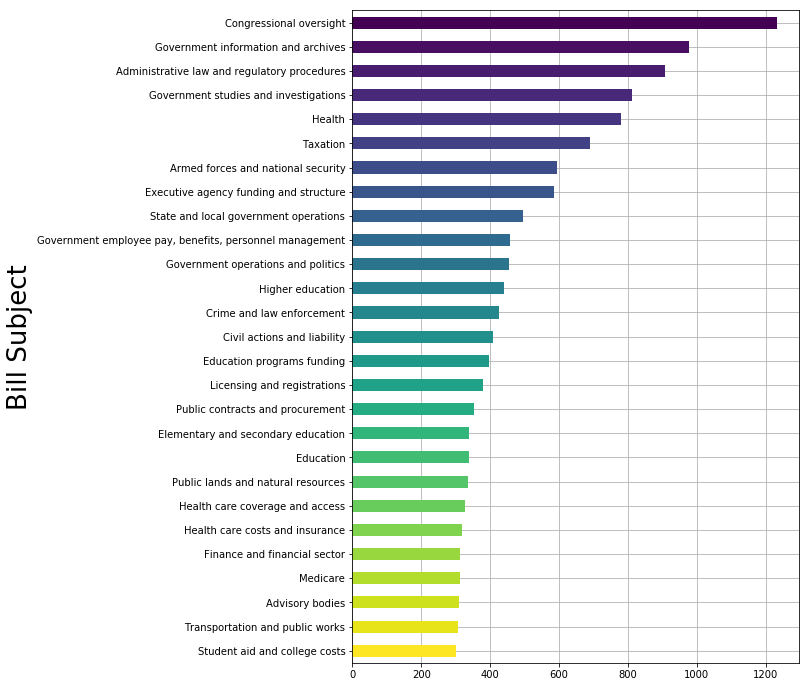

In [130]:
fig, ax = plt.subplots(figsize=(8, 12))
color = matplotlib.cm.viridis_r(np.linspace(0, 1, cutoff.subject.nunique()))
cutoff.groupby('subject').count()['bill_id'].sort_values().plot(kind='barh', ax=ax, color=color); 
ax.grid(); ax.set_axisbelow(True); ax.set_ylabel('Bill Subject', size=26);

# Separate enacted_as.

In [245]:
data_enacted_as = data_agg[['enacted_as', 'bill_id']].copy()
del data_agg['enacted_as']

In [248]:
data_enacted_as['enacted_as'].nunique()

216

In [250]:
data_enacted_as = data_enacted_as.dropna().reset_index(drop=True)

In [251]:
data_enacted_as.head()

,enacted_as,bill_id
0,"{'law_type': 'public', 'number': '169', 'congr...",hr2458-114
1,"{'law_type': 'public', 'number': '317', 'congr...",hr6450-114
2,"{'law_type': 'public', 'number': '231', 'congr...",hr2494-114
3,"{'law_type': 'public', 'number': '301', 'congr...",hr5687-114
4,"{'law_type': 'public', 'number': '189', 'congr...",hr3114-114


In [252]:
data_enacted_as['enacted_as'].apply(ast.literal_eval).

0      {'law_type': 'public', 'number': '169', 'congr...
1      {'law_type': 'public', 'number': '317', 'congr...
2      {'law_type': 'public', 'number': '231', 'congr...
3      {'law_type': 'public', 'number': '301', 'congr...
4      {'law_type': 'public', 'number': '189', 'congr...
5      {'law_type': 'public', 'number': '158', 'congr...
6      {'law_type': 'public', 'number': '277', 'congr...
7      {'law_type': 'public', 'number': '90', 'congre...
8      {'law_type': 'public', 'number': '43', 'congre...
9      {'law_type': 'public', 'number': '291', 'congr...
10     {'law_type': 'public', 'number': '318', 'congr...
11     {'law_type': 'public', 'number': '79', 'congre...
12     {'law_type': 'public', 'number': '292', 'congr...
13     {'law_type': 'public', 'number': '123', 'congr...
14     {'law_type': 'public', 'number': '305', 'congr...
15     {'law_type': 'public', 'number': '286', 'congr...
16     {'law_type': 'public', 'number': '28', 'congre...
17     {'law_type': 'public', '